In [1]:
import keras
import tensorflow as tf

In [2]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from glob import glob
from keras_unet.models import custom_unet, satellite_unet
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras_unet.utils import plot_segm_history

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
# training data
base_dir = Path(r'e:/Google Drive/research\projects/utica/model_save/2017/data/train')
mask_dir = base_dir.joinpath('mask')
train_image_dir = base_dir.joinpath('images')
trees_mask_dir = mask_dir.joinpath('trees')
building_mask_dir = mask_dir.joinpath('building')
pavement_mask_dir = mask_dir.joinpath('pavement')

In [4]:
I, N, M = 60, 256, 256

In [5]:
os.listdir(mask_dir)

['building', 'desktop.ini', 'pavement', 'trees']

In [6]:
trees_mask_dir

WindowsPath('e:/Google Drive/research/projects/utica/model_save/2017/data/train/mask/trees')

In [7]:
def make_path(img_dir, prefix, number):
    return os.path.join(img_dir, f"{prefix}_{number}.tif")

In [8]:
def img_number(fpath: str) -> int:
    return int(os.path.splitext(os.path.split(fpath)[1])[0].split('_')[-1])

In [9]:
test = gdal.Open(r'e:/Google Drive/research/projects/utica/model_save/2017/data/train/images/train_1.tif', gdal.GA_ReadOnly)

In [10]:
test3 = test.GetRasterBand(1).ReadAsArray()

In [11]:
test2 = test.GetRasterBand(2).ReadAsArray()

In [12]:
test4 = test.GetRasterBand(3).ReadAsArray()

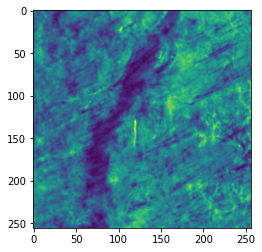

In [13]:
plt.imshow(test2)

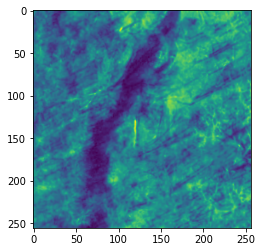

In [14]:
plt.imshow(test3)

In [16]:
V = 3

In [17]:

def load_image_no_trim(path: str) -> np.ndarray:
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    return ds.GetRasterBand(1).ReadAsArray()

In [18]:
import typing as t

def load_image_rgb(path: str, shape: t.Tuple[int,int,int], dtype) -> np.ndarray:
    image = np.zeros(shape = shape, dtype=dtype)
    ds= gdal.Open(path, gdal.GA_ReadOnly)
    for i in (1, 2, 3):
        image[:, :, i-1] = ds.GetRasterBand(i).ReadAsArray()
    return image

In [19]:
def sorted_paths(img_dir: Path):
    return sorted(glob(img_dir.joinpath('*.tif').as_posix()), key=img_number)

In [20]:
def load_stack_safely(shape, dtype, img_dir, prefix):
    """
    Load a stack of images from disk into an ndarray.

    Performs the load potentially several times, to ensure that values
    stabilize. Google seems to be...tricky...
    """
    last_sum = 0
    while True:
        stack = np.zeros(shape=shape, dtype=dtype)
        for i in range(shape[0]):
            image_path = make_path(img_dir, prefix, i + 1)
            if not os.path.isfile(image_path):
                print("skipping", image_path)
                continue
            stack[i, :, :] = load_image_no_trim(image_path)
        if stack.sum() == last_sum:
            break
        last_sum = stack.sum()
    return stack

In [21]:
def load_stack_safely_rgb(shape, dtype, img_dir, prefix):
    """
    Load a stack of images from disk into an ndarray.

    Performs the load potentially several times, to ensure that values
    stabilize. Google seems to be...tricky...
    """
    last_sum = 0
    while True:
        stack = np.zeros(shape=shape, dtype=dtype)
        for i in range(shape[0]):
            image_path = make_path(img_dir, prefix, i + 1)
            if not os.path.isfile(image_path):
                print("skipping", image_path)
                continue
            stack[i, : , : , : ] = load_image_rgb(image_path, (shape[1], shape[2], shape[3]), dtype)
        if stack.sum() == last_sum:
            break
        last_sum = stack.sum()
    return stack

In [22]:

train_images = load_stack_safely_rgb((I, N, M, V), np.float32, train_image_dir, "train")

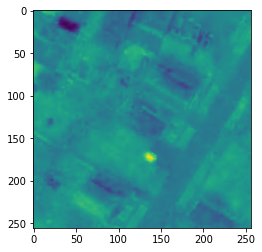

In [23]:
plt.imshow(train_images[20,:,:,0]- train_images[20,:,:,2])

In [24]:

tree_masks = load_stack_safely((I, N, M), np.int8, trees_mask_dir, "tree_mask")
building_masks = load_stack_safely((I, N, M), np.int8, building_mask_dir, "building_mask")
pavement_masks = load_stack_safely((I, N, M), np.int8, pavement_mask_dir, "pavement_mask")

skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\trees\tree_mask_3.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\trees\tree_mask_5.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\trees\tree_mask_9.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\trees\tree_mask_10.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\trees\tree_mask_15.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\trees\tree_mask_17.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\trees\tree_mask_30.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\trees\tree_mask_31.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\trees\tree_mask_34.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\da

skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\pavement\pavement_mask_40.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\pavement\pavement_mask_45.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\pavement\pavement_mask_47.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\pavement\pavement_mask_50.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\pavement\pavement_mask_51.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\pavement\pavement_mask_56.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\pavement\pavement_mask_57.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\pavement\pavement_mask_59.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\train\mask\pavement\pavement_mask_1.tif
sk

In [26]:
# training data stratified
base_dirS = Path(r'e:/Google Drive/research\projects/utica/model_save/2017/data_strat')
mask_dirS = base_dirS.joinpath('mask')
train_image_dirS = base_dirS.joinpath('images')
trees_mask_dirS = mask_dirS.joinpath('trees')
building_mask_dirS = mask_dirS.joinpath('building')
pavement_mask_dirS = mask_dirS.joinpath('pavement')

In [27]:
W, N, M = 40, 256, 256
tree_masks = load_stack_safely((W, N, M), np.int8, trees_mask_dirS, "tree_mask")
building_masks = load_stack_safely((W, N, M), np.int8, building_mask_dirS, "building_mask")
pavement_masks = load_stack_safely((W, N, M), np.int8, pavement_mask_dirS, "pavement_mask")

skipping e:\Google Drive\research\projects\utica\model_save\2017\data_strat\mask\trees\tree_mask_27.tif


ValueError: could not broadcast input array from shape (109,256) into shape (256,256)

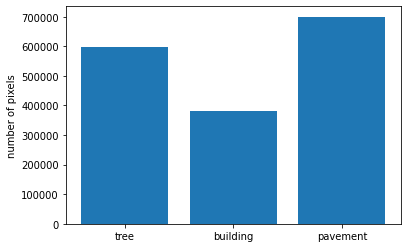

In [77]:
fig, ax = plt.subplots()
ax.bar(range(3), [tree_masks.sum(), building_masks.sum(), pavement_masks.sum()])
ax.set_xticks((0, 1, 2))
ax.set_xticklabels(('tree', 'building', 'pavement'))
plt.ylabel('number of pixels')
plt.show()

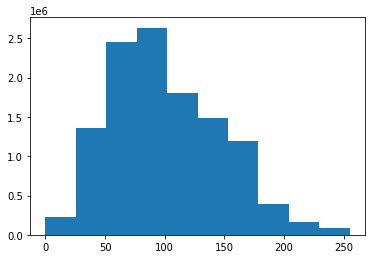

In [78]:
plt.hist(train_images.flatten())
plt.show()

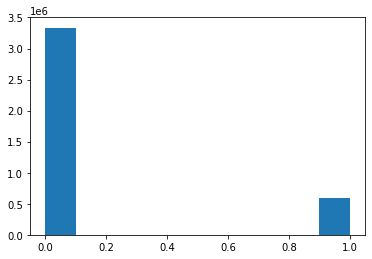

In [79]:
plt.hist(tree_masks.flatten())
plt.show()

In [80]:
model = satellite_unet(
    (N, M, 3),
    3,
    # dropout_type="spatial"
)

In [81]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded],
    
)

In [82]:
Y = np.zeros(shape=(I, N, M, 3), dtype=np.int8)
Y[:, :, :, 0] = tree_masks
Y[:, :, :, 1] = building_masks
Y[:, :, :, 2] = pavement_masks

In [83]:
Y.shape, tree_masks.shape

((60, 256, 256, 3), (60, 256, 256))

In [84]:
history = model.fit(
    train_images.reshape(I, N, M, 3),
    Y,
    epochs=150,
)

Epoch 1/150
2/2 [==============================] - 36s 15s/step - loss: 0.5970 - iou: 0.1524 - iou_thresholded: 0.1848
Epoch 2/150
2/2 [==============================] - 33s 15s/step - loss: 0.3946 - iou: 0.2234 - iou_thresholded: 0.3242
Epoch 3/150
2/2 [==============================] - 31s 15s/step - loss: 0.2910 - iou: 0.2778 - iou_thresholded: 0.3931
Epoch 4/150
2/2 [==============================] - 31s 15s/step - loss: 0.2536 - iou: 0.3211 - iou_thresholded: 0.4269
Epoch 5/150
2/2 [==============================] - 32s 15s/step - loss: 0.2436 - iou: 0.3398 - iou_thresholded: 0.4274
Epoch 6/150
2/2 [==============================] - 33s 15s/step - loss: 0.2201 - iou: 0.3968 - iou_thresholded: 0.4952
Epoch 7/150
2/2 [==============================] - 32s 15s/step - loss: 0.2098 - iou: 0.4011 - iou_thresholded: 0.5005
Epoch 8/150
2/2 [==============================] - 32s 15s/step - loss: 0.2046 - iou: 0.3984 - iou_thresholded: 0.5088
Epoch 9/150
2/2 [==============================]

2/2 [==============================] - 31s 14s/step - loss: 0.0118 - iou: 0.9482 - iou_thresholded: 0.9659
Epoch 138/150
2/2 [==============================] - 31s 15s/step - loss: 0.0116 - iou: 0.9494 - iou_thresholded: 0.9668
Epoch 139/150
2/2 [==============================] - 31s 14s/step - loss: 0.0124 - iou: 0.9482 - iou_thresholded: 0.9642
Epoch 140/150
2/2 [==============================] - 31s 14s/step - loss: 0.0180 - iou: 0.9340 - iou_thresholded: 0.9509
Epoch 141/150
2/2 [==============================] - 31s 15s/step - loss: 0.0127 - iou: 0.9456 - iou_thresholded: 0.9617
Epoch 142/150
2/2 [==============================] - 31s 14s/step - loss: 0.0142 - iou: 0.9416 - iou_thresholded: 0.9579
Epoch 143/150
2/2 [==============================] - 31s 14s/step - loss: 0.0156 - iou: 0.9378 - iou_thresholded: 0.9553
Epoch 144/150
2/2 [==============================] - 31s 15s/step - loss: 0.0129 - iou: 0.9466 - iou_thresholded: 0.9631
Epoch 145/150
2/2 [===========================

In [85]:

modelsave_path = Path(r'e:\Google Drive\research\projects\utica\model_save\2017\model_256\saved_model256')

In [86]:
model.save(modelsave_path)

INFO:tensorflow:Assets written to: e:\Google Drive\research\projects\utica\model_save\2017\model_256\saved_model256\assets


In [88]:
Y_pred = model.predict(train_images.reshape(I, N, M, 3))

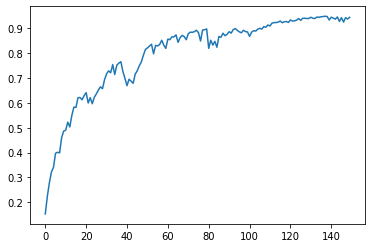

In [89]:
plt.plot(history.history['iou'])

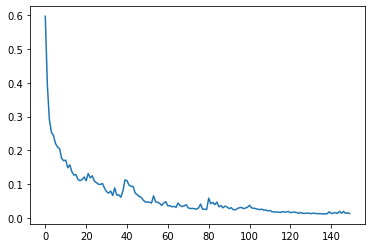

In [90]:
plt.plot(history.history['loss'])

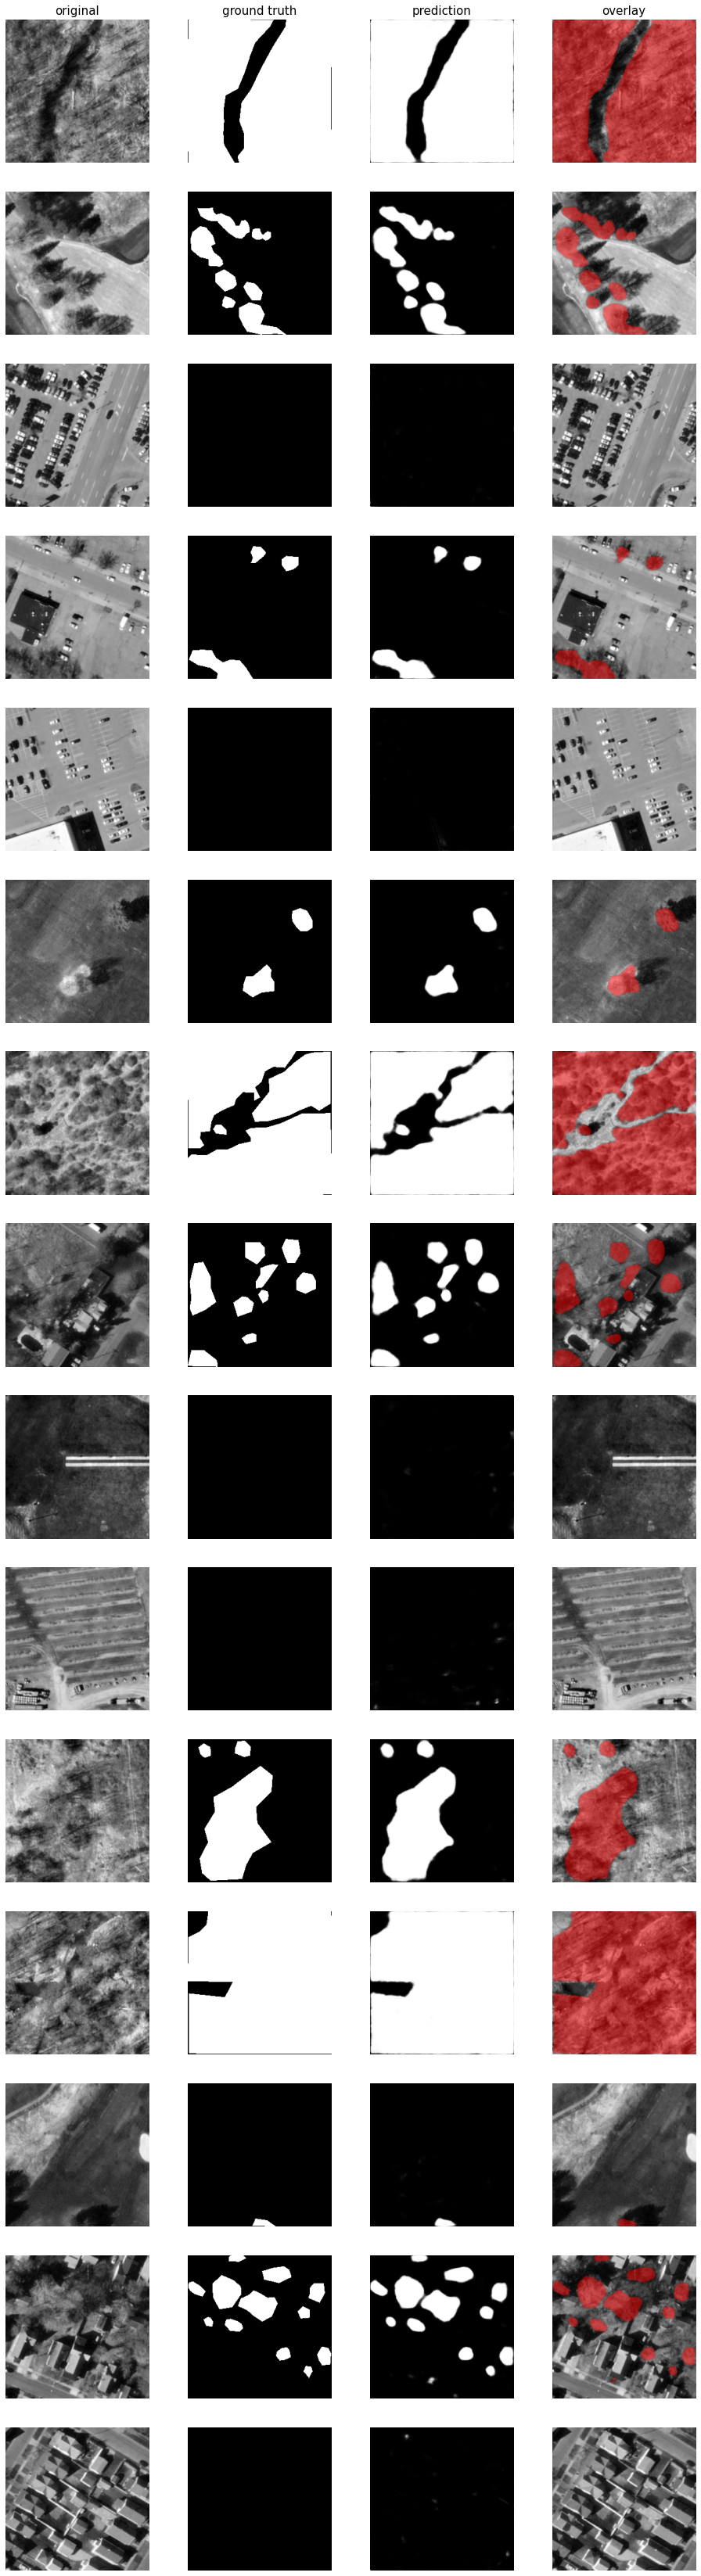

In [93]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(I, N, M, 3)[:,:,:,0], 
    mask_imgs=Y[:, :, :, 0], 
    pred_imgs=Y_pred[:, :, :, 0], 
    nm_img_to_plot=15
  )

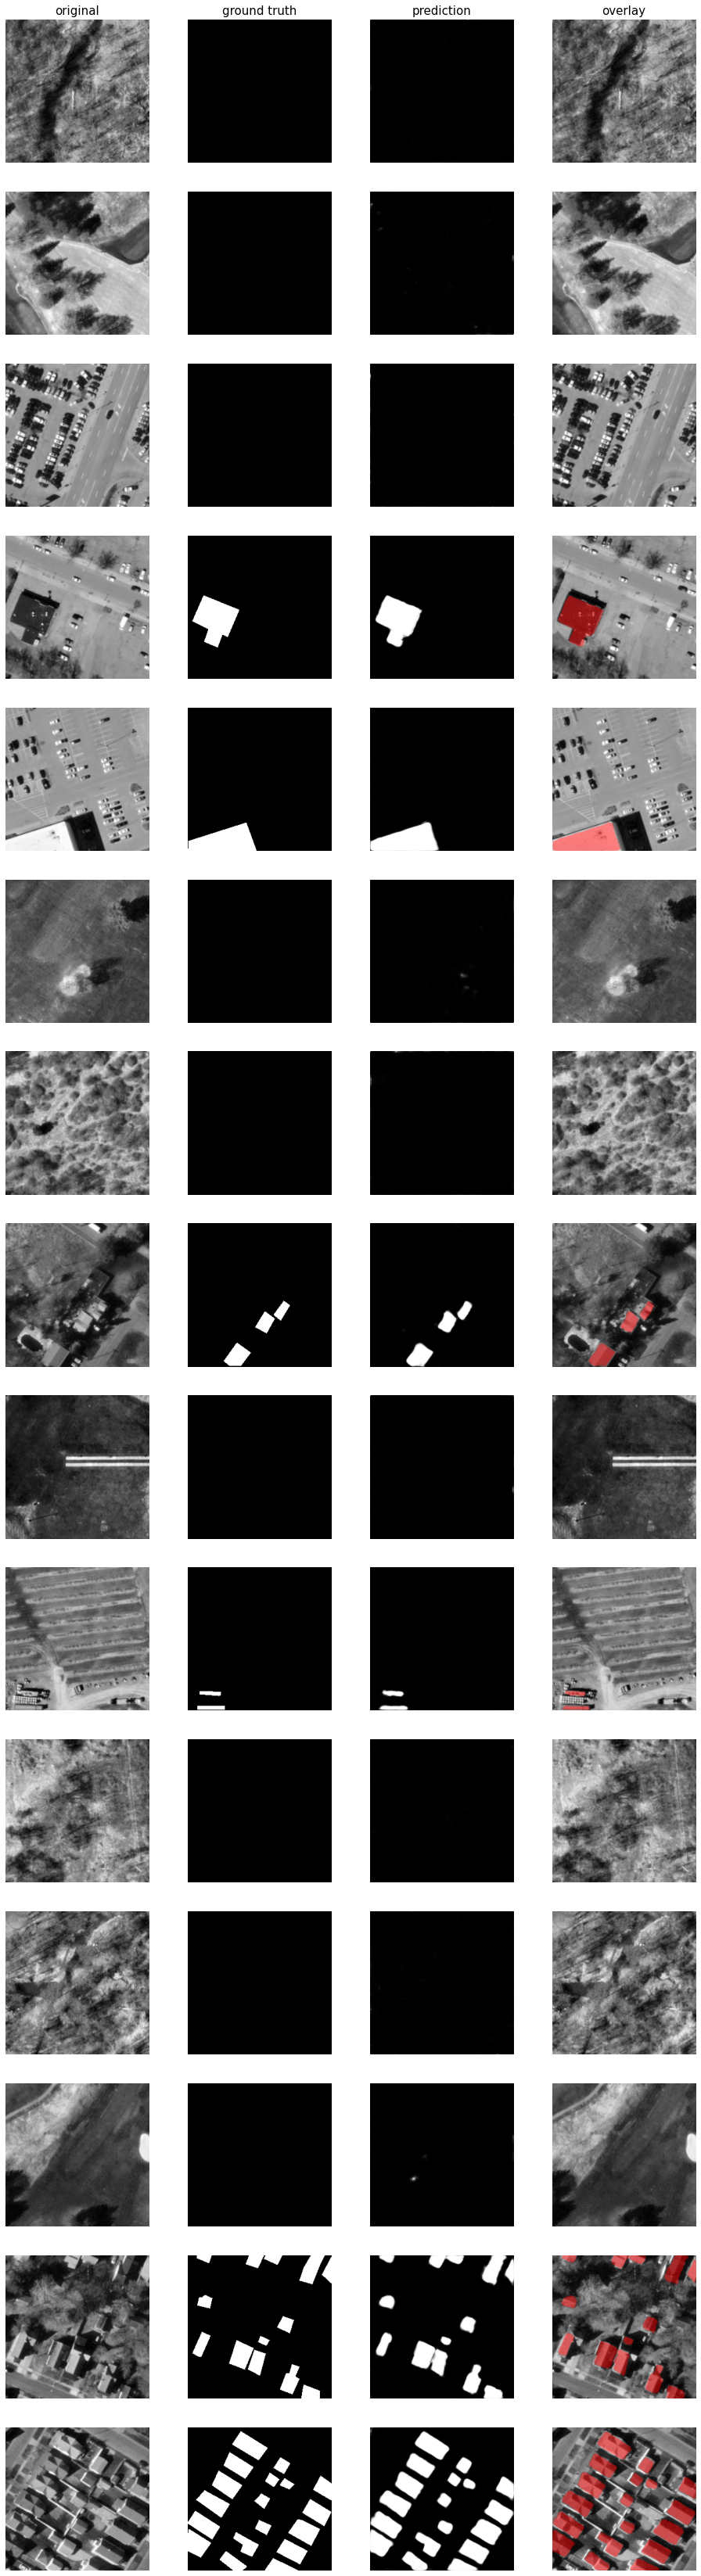

In [95]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(I, N, M, 3)[:,:,:,0], 
    mask_imgs=Y[:, :, :, 1], 
    pred_imgs=Y_pred[:, :, :, 1], 
    nm_img_to_plot=15
  )

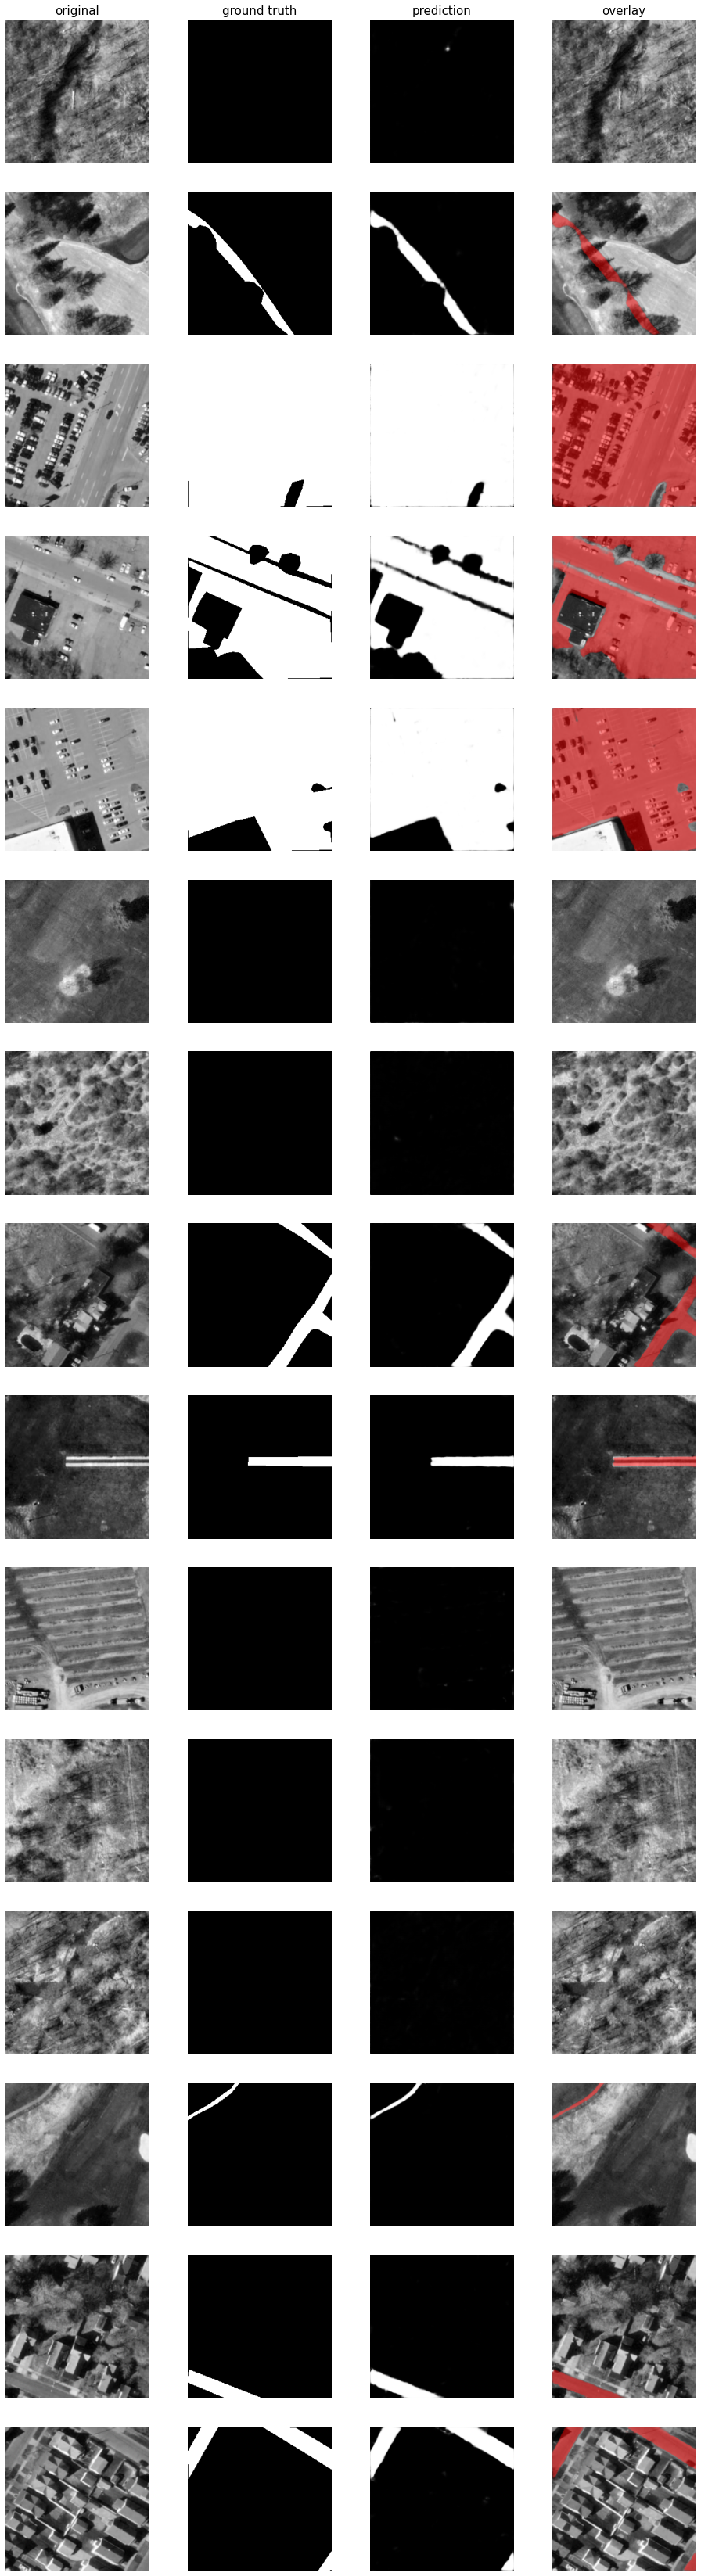

In [96]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(I, N, M, 3)[:,:,:,0], 
    mask_imgs=Y[:, :, :, 2], 
    pred_imgs=Y_pred[:, :, :, 2], 
    nm_img_to_plot=15
  )

In [105]:
# validation data
base_dirV = Path(r'e:/Google Drive/research/projects/utica/model_save/2017/data/valid')
mask_dirV = base_dirV.joinpath('mask')
train_image_dirV = base_dirV.joinpath('images')
trees_mask_dirV = mask_dirV.joinpath('trees')
building_mask_dirV = mask_dirV.joinpath('building')
pavement_mask_dirV = mask_dirV.joinpath('pavement')

In [106]:
K, N, M = 20, 256, 256

In [108]:
valid_images = load_stack_safely_rgb((K, N, M,V), np.float32, train_image_dirV, "valid")

In [109]:

tree_valid = load_stack_safely((K, N, M), np.int8, trees_mask_dirV, "tree_mask")
building_valid = load_stack_safely((K, N, M), np.int8, building_mask_dirV, "building_mask")
pavement_valid = load_stack_safely((K, N, M), np.int8, pavement_mask_dirV, "pavement_mask")

skipping e:\Google Drive\research\projects\utica\model_save\2017\data\valid\mask\building\building_mask_2.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\valid\mask\building\building_mask_3.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\valid\mask\building\building_mask_6.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\valid\mask\building\building_mask_7.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\valid\mask\building\building_mask_15.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\valid\mask\building\building_mask_2.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\valid\mask\building\building_mask_3.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\valid\mask\building\building_mask_6.tif
skipping e:\Google Drive\research\projects\utica\model_save\2017\data\valid\mask\building\building_mask_7.tif
skipping 

In [110]:
Yvalid = np.zeros(shape=(K, N, M, 3), dtype=np.int8)
Yvalid[:, :, :, 0] = tree_valid
Yvalid[:, :, :, 1] = building_valid
Yvalid[:, :, :, 2] = pavement_valid

In [111]:
Y_valid = model.predict(valid_images.reshape(K, N, M, 3))

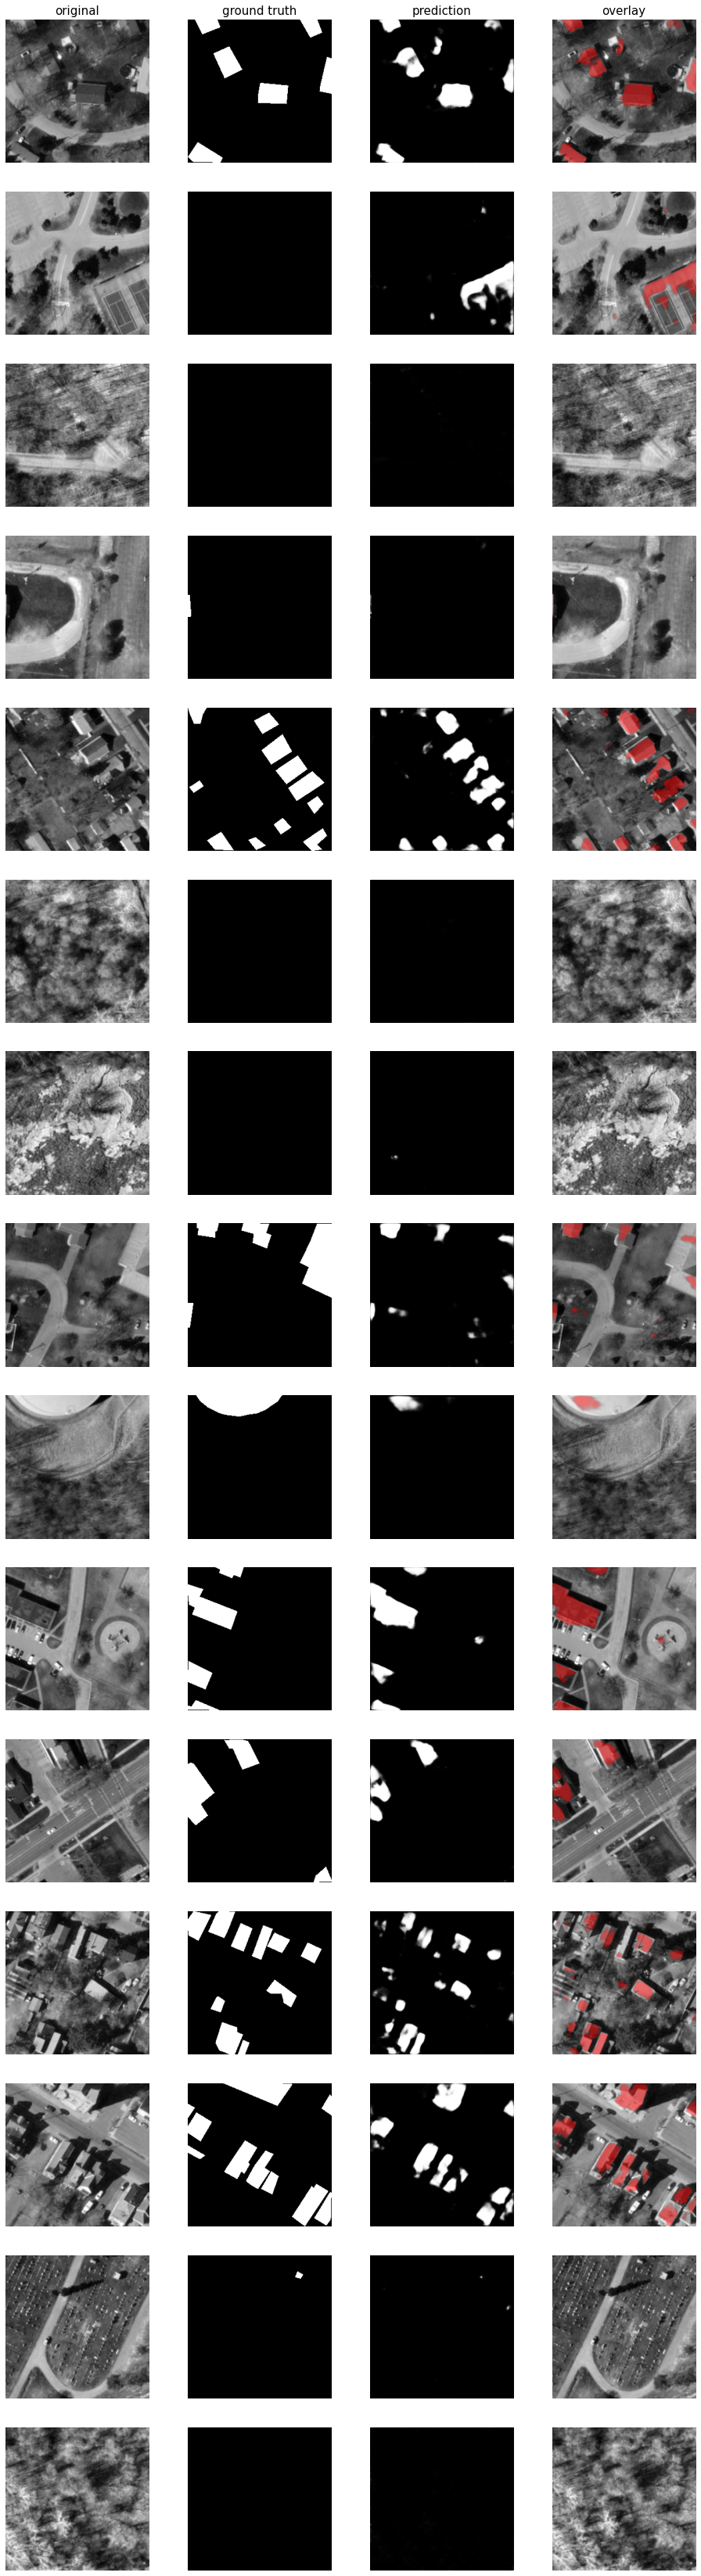

In [112]:
plot_imgs(
    org_imgs=valid_images.reshape(K, N, M, 3)[:,:,:,0], 
    mask_imgs=Yvalid[:, :, :, 1], 
    pred_imgs=Y_valid[:, :, :, 1], 
    nm_img_to_plot=15
  )

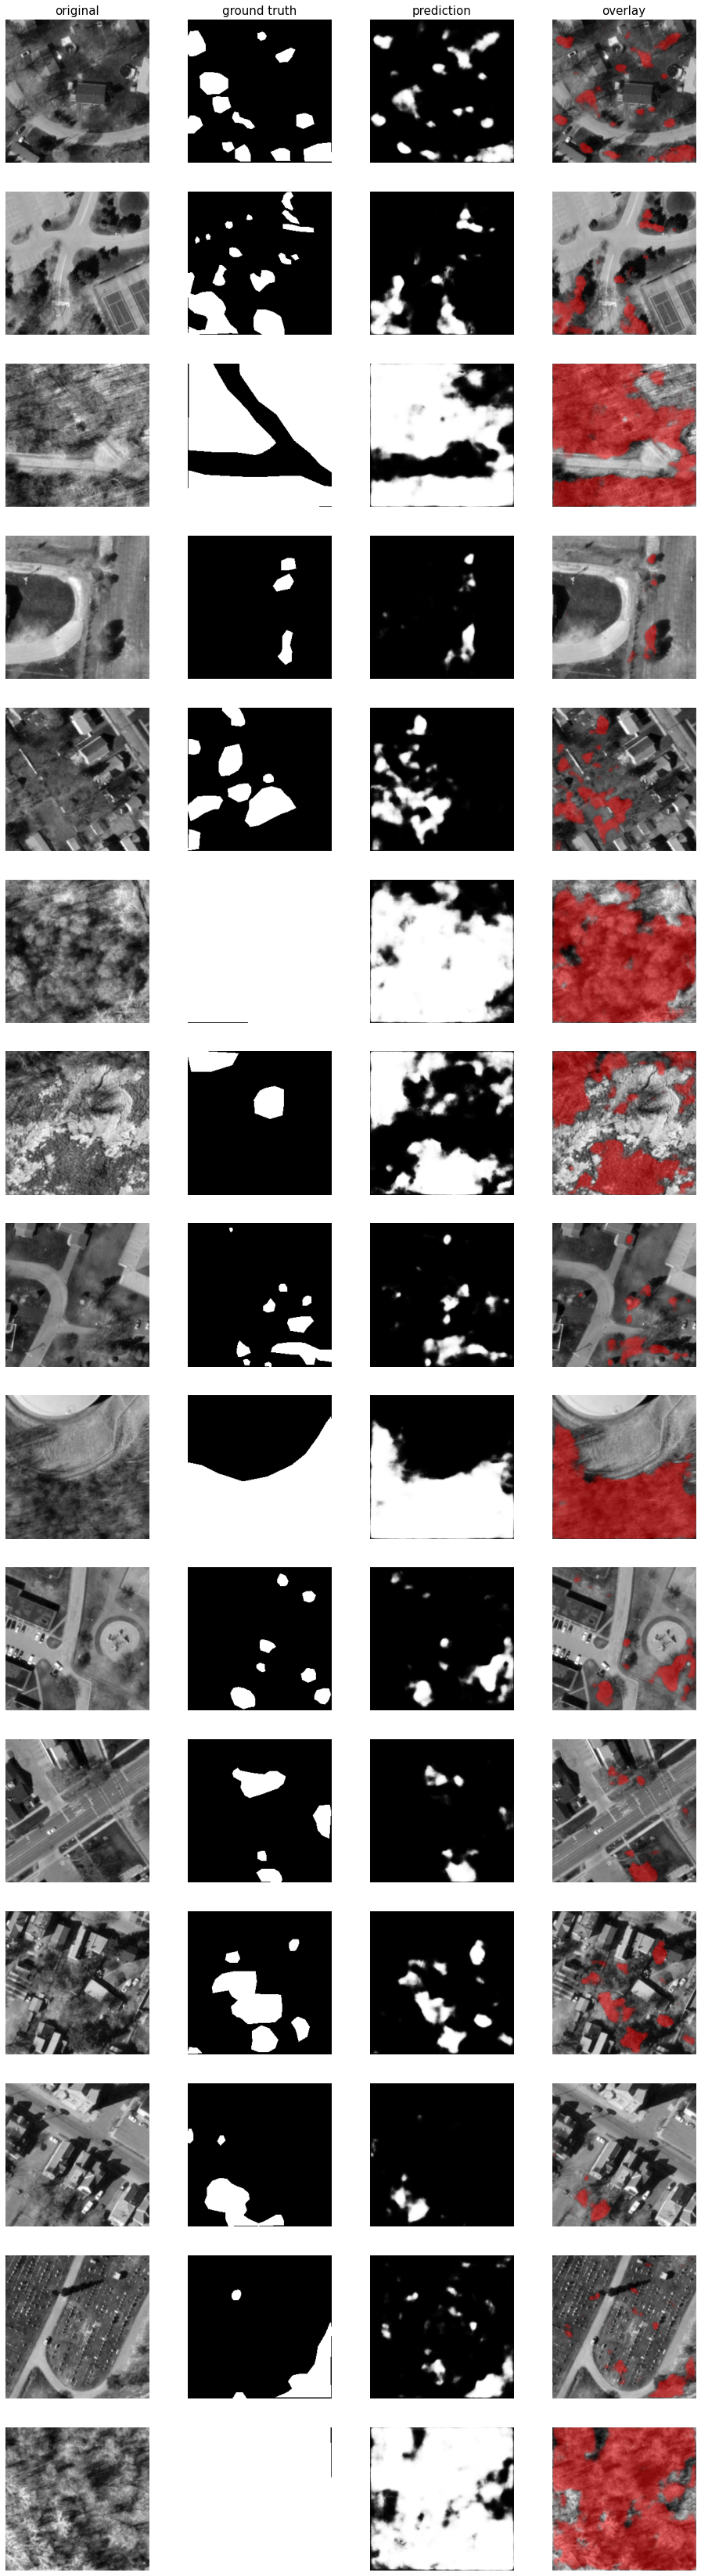

In [114]:
plot_imgs(
    org_imgs=valid_images.reshape(K, N, M, 3)[:,:,:,0], 
    mask_imgs=Yvalid[:, :, :, 0], 
    pred_imgs=Y_valid[:, :, :, 0], 
    nm_img_to_plot=15
  )

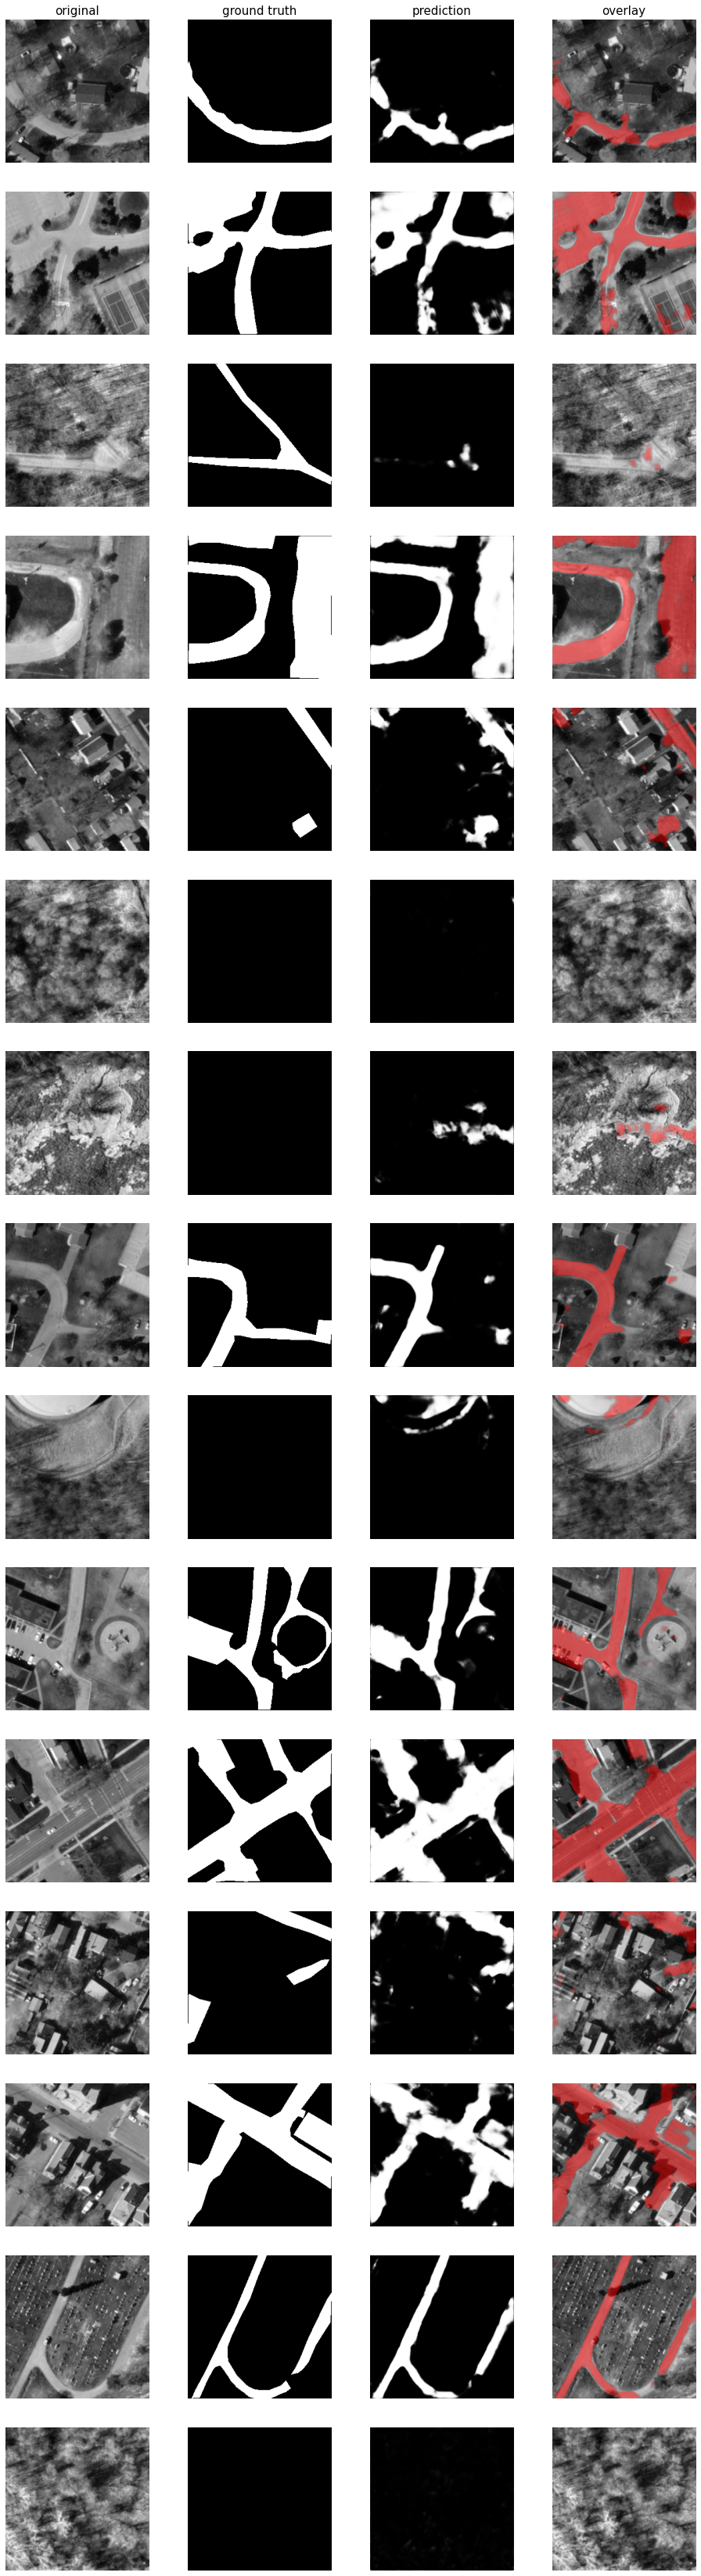

In [115]:
plot_imgs(
    org_imgs=valid_images.reshape(K, N, M, 3)[:,:,:,0], 
    mask_imgs=Yvalid[:, :, :, 2], 
    pred_imgs=Y_valid[:, :, :, 2], 
    nm_img_to_plot=15
  )

In [116]:
Y_valid[0,0,0,0]

0.013531148

In [117]:
treePredict = Y_valid[:,:,:,0]

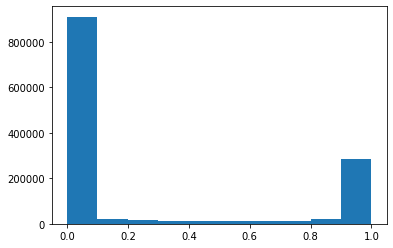

In [118]:
plt.hist(treePredict.flatten())
plt.show()

In [119]:
# prediction data
base_dirP = Path(r'E:/Google Drive/research/projects/utica/model_save/2017/img_tile_256/image')

In [120]:
J, N, M = 7930, 256, 256

In [121]:
predict_img = load_stack_safely_rgb((J, N, M,V), np.float32,base_dirP, "predict")

c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [122]:
predict_img.shape

(7930, 256, 256, 3)

In [123]:
Y_all = model.predict(predict_img.reshape(J, N, M, 3))

In [124]:
Y_all.shape

(7930, 256, 256, 3)

In [154]:
# prediction data offset 2 (25 pixels)

base_dirP2 = Path(r'e:/Google Drive/research/projects/utica/model_save/2017/img_tile_256/image_2')
predict_img2 = load_stack_safely_rgb((J, N, M, V), np.float32,base_dirP2, "predict")

In [156]:
Y_all2 = model.predict(predict_img2.reshape(J, N, M, 3))

In [157]:
Y_all2.shape

(7930, 256, 256, 3)

In [168]:
# prediction data offset 3 (100 pixels)
L, N, M = 7740, 256, 256
base_dirP3 = Path(r'e:/Google Drive/research/projects/utica/model_save/2017/img_tile_256/image_3')
predict_img3 = load_stack_safely_rgb((L, N, M, V), np.float32,base_dirP3, "predict")

In [169]:
Y_all3 = model.predict(predict_img3.reshape(L, N, M, 3))
Y_all3.shape

(7740, 256, 256, 3)

In [63]:
driver = gdal.GetDriverByName("GTiff")

In [64]:
driver.Register()

2

In [65]:
def load_stack_nt(shape, dtype, img_dir, prefix):
    stack = np.zeros(shape=shape, dtype=dtype)
    for i in range(shape[0]):
        image_path = make_path(img_dir, prefix, i + 1)
        stack[i, :, :] = load_image_no_trim(image_path)
    return stack

In [125]:
def save_predict_valid( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTree = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTree.SetGeoTransform(gt)
        outTree.SetProjection(pt)
        outBandTree = outTree.GetRasterBand(1)
        outBandTree.WriteArray(Y_valid[i,:,:,0])
        outBandTree.SetNoDataValue(np.nan)
        outBandTree.FlushCache()
        outBandTree = None
        outTree = None

In [128]:
driver = gdal.GetDriverByName("GTiff")
driver.Register()

2

In [130]:
tree_valid_dir = r'e:/Google Drive/research\projects/utica/model_save/2017/prediction_256/valid/tree'
save_predict_valid(nImg = 20,xdim= 256, ydim= 256,img_dir = tree_valid_dir,prefix = "tree_predict",orig_dir = train_image_dirV , prefix_orig = "valid")

In [131]:
def save_predict_validB( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        build_ds = gdal.Open(orig_path)
        gt = build_ds.GetGeoTransform()
        pt = build_ds.GetProjection()
        outBuild = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outBuild.SetGeoTransform(gt)
        outBuild.SetProjection(pt)
        outBandBuild = outBuild.GetRasterBand(1)
        outBandBuild.WriteArray(Y_valid[i,:,:,1])
        outBandBuild.SetNoDataValue(np.nan)
        outBandBuild.FlushCache()
        outBandBuild = None
        outBuild = None

In [133]:
build_valid_dir = r'e:/Google Drive/research\projects/utica/model_save/2017/prediction_256/valid/building'
save_predict_validB(nImg = 20,xdim= 256, ydim= 256,img_dir =build_valid_dir,prefix = "building_predict",orig_dir = train_image_dirV , prefix_orig = "valid")

In [134]:
def save_predict_validP( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        build_ds = gdal.Open(orig_path)
        gt = build_ds.GetGeoTransform()
        pt = build_ds.GetProjection()
        outPave = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outPave.SetGeoTransform(gt)
        outPave.SetProjection(pt)
        outBandPave = outPave.GetRasterBand(1)
        outBandPave.WriteArray(Y_valid[i,:,:,2])
        outBandPave.SetNoDataValue(np.nan)
        outBandPave.FlushCache()
        outBandPave = None
        outPave = None

In [135]:
pave_valid_dir = r'e:/Google Drive/research\projects/utica/model_save/2017/prediction_256/valid/pavement'
save_predict_validP(nImg = 20,xdim= 256, ydim= 256,img_dir =pave_valid_dir,prefix = "pavement_predict",orig_dir = train_image_dirV , prefix_orig = "valid")

In [138]:
# save map prediction

def save_predict_build( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None


In [139]:
predict_build_dir = r'e:/Google Drive/research/projects/utica/model_save/2017/prediction_256/image/building'
save_predict_build(nImg = 7930,xdim= 256, ydim= 256,img_dir = predict_build_dir, prefix = "building",orig_dir = base_dirP , prefix_orig = "predict")

In [140]:
def save_predict_tree( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [141]:
predict_tree_dir = r'e:/Google Drive/research/projects/utica/model_save/2017/prediction_256/image/tree'
save_predict_tree(nImg = 7930,xdim= 256, ydim= 256,img_dir = predict_tree_dir, prefix = "tree",orig_dir = base_dirP , prefix_orig = "predict")

In [166]:
def save_predict_pave( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [167]:
predict_pave_dir = r'e:/Google Drive/research/projects/utica/model_save/2017/prediction_256/image/pavement'
save_predict_pave(nImg = 7930,xdim= 256, ydim= 256,img_dir = predict_pave_dir, prefix = "pavement",orig_dir = base_dirP , prefix_orig = "predict")

In [158]:

# save map prediction

def save_predict_build2( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all2[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [159]:
predict_build_dir2 = r'e:/Google Drive/research/projects/utica/model_save/2017/prediction_256/image_2/building'
save_predict_build2(nImg = 7930,xdim= 256, ydim= 256,img_dir = predict_build_dir2, prefix = "building",orig_dir = base_dirP2 , prefix_orig = "predict")

In [160]:
def save_predict_tree2( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all2[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [161]:
predict_tree_dir2 = r'e:/Google Drive/research/projects/utica/model_save/2017/prediction_256/image_2/tree'
save_predict_tree2(nImg = 7930,xdim= 256, ydim= 256,img_dir = predict_tree_dir2, prefix = "tree",orig_dir = base_dirP2 , prefix_orig = "predict")

In [164]:
def save_predict_pave2( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all2[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [165]:

predict_pave_dir2 = r'e:/Google Drive/research/projects/utica/model_save/2017/prediction_256/image_2/pavement'
save_predict_pave2(nImg = 7930,xdim= 256, ydim= 256,img_dir = predict_pave_dir2, prefix = "pavement",orig_dir = base_dirP2 , prefix_orig = "predict")

In [170]:
def save_predict_build3( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all3[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [171]:
predict_build_dir3 = r'e:/Google Drive/research/projects/utica/model_save/2017/prediction_256/image_3/building'
save_predict_build3(nImg = 7740,xdim= 256, ydim= 256,img_dir = predict_build_dir3, prefix = "building",orig_dir = base_dirP3 , prefix_orig = "predict")

In [172]:
def save_predict_tree3( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all3[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [173]:
predict_tree_dir3 = r'e:/Google Drive/research/projects/utica/model_save/2017/prediction_256/image_3/tree'
save_predict_tree3(nImg = 7740,xdim= 256, ydim= 256,img_dir = predict_tree_dir3, prefix = "tree",orig_dir = base_dirP3 , prefix_orig = "predict")

In [174]:
def save_predict_pave3( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all3[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [175]:
predict_pave_dir3 = r'e:/Google Drive/research/projects/utica/model_save/2017/prediction_256/image_3/pavement'
save_predict_pave(nImg = 7740,xdim= 256, ydim= 256,img_dir = predict_pave_dir3, prefix = "pavement",orig_dir = base_dirP3 , prefix_orig = "predict")

In [176]:
#save valid masks so have raster of zeros for images missing a landcover type
def save_mask_valid( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Yvalid[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [180]:
tree_m_dir = r'e:/Google Drive/research/projects/utica/model_save/2017/data/valid_out/trees'
save_mask_valid(nImg = 20,xdim= 256, ydim= 256,img_dir = tree_m_dir, prefix = "tree_mask",orig_dir = train_image_dirV , prefix_orig = "valid")

In [179]:
train_image_dirV

WindowsPath('e:/Google Drive/research/projects/utica/model_save/2017/data/valid/images')

In [181]:
def save_mask_validB( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Yvalid[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [184]:
build_m_dir = r'e:/Google Drive/research/projects/utica/model_save/2017/data/valid_out/building'
save_mask_validB(nImg = 20,xdim= 256, ydim= 256,img_dir = build_m_dir, prefix = "build_mask",orig_dir = train_image_dirV , prefix_orig = "valid")

In [183]:
def save_mask_validP( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Yvalid[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [185]:
pave_m_dir = r'e:/Google Drive/research/projects/utica/model_save/2017/data/valid_out/pavement'
save_mask_validP(nImg = 20,xdim= 256, ydim= 256,img_dir = pave_m_dir, prefix = "pave_mask",orig_dir = train_image_dirV , prefix_orig = "valid")